# 📊 Metriche di Valutazione in YOLO

Questo documento descrive nel dettaglio le principali **metriche di valutazione** e **loss functions** utilizzate per misurare le prestazioni di un modello YOLO nel contesto di object detection (es. rilevamento buche stradali).

## 📌 Cos'è l'IoU (Intersection over Union)?

Molte metriche si basano sulla **sovrapposizione tra i bounding box predetti e quelli reali**. Si usa il coefficiente **IoU**, definito come:

$$
\text{IoU} = \frac{\text{area}(B_{pred} \cap B_{gt})}{\text{area}(B_{pred} \cup B_{gt})}
$$

Dove:
- $B_{pred}$ è il box predetto,
- $B_{gt}$ è il box ground truth.

## 🔹 1. `metrics/mAP50(B)` — *Mean Average Precision @ IoU=0.50*

### 📘 Definizione
- È la media della **Average Precision** (AP) calcolata con soglia **IoU ≥ 0.50**.
- Utilizzata storicamente in benchmark come **PASCAL VOC**.

### 📐 Formula
$$
\text{mAP@50} = \frac{1}{N} \sum_{i=1}^N AP_i^{(IoU \geq 0.5)}
$$

### ✅ Interpretazione
- Valori **vicini a 1.0** indicano un modello altamente preciso.
- Valori < 0.5 suggeriscono molte predizioni inaccurate.

### 📊 Esempio
Il modello rileva 10 oggetti, 8 dei quali hanno IoU > 0.5 → `mAP50 ≈ 0.8`.

## 🔹 2. `metrics/mAP50-95(B)` — *Mean Average Precision (COCO)*

### 📘 Definizione
- Calcolata come media di AP su **10 soglie di IoU**: da **0.50 a 0.95** con step di 0.05.

### 📐 Formula
$$
\text{mAP@50–95} = \frac{1}{10N} \sum_{t=0.50}^{0.95} \sum_{i=1}^{N} AP_i^{(IoU \geq t)}
$$

### ✅ Interpretazione
- Più rigorosa della mAP50, premia bounding box **precisi**.
- È lo standard ufficiale in **COCO**.

### 📊 Esempio
Un box che copre l’oggetto ma è decentrato avrà `mAP50` alta ma `mAP50-95` bassa.

## 🔹 3. `metrics/precision(B)` — *Precisione*

### 📘 Definizione
Misura la percentuale di predizioni **corrette** tra quelle effettuate.

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

Dove:
- TP = True Positives (IoU ≥ soglia, predizioni corrette)
- FP = False Positives (IoU < soglia o box duplicati)

### ✅ Interpretazione
- Alta precisione → pochi **falsi positivi**.
- Utile per evitare segnalazioni errate.

### 📊 Esempio
Il modello rileva 10 oggetti, ma solo 7 sono corretti → precision = 0.7

## 🔹 4. `metrics/recall(B)` — *Recall*

### 📘 Definizione
Misura la percentuale di oggetti **realmente presenti** che il modello riesce a trovare.

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

Dove:
- FN = False Negatives (IoU < soglia, oggetti mancati)

### ✅ Interpretazione
- Alto recall → il modello **non perde oggetti**.
- Utile in ambiti critici (es. buche stradali non rilevate = pericolo).

### 📊 Esempio
Ci sono 10 oggetti reali, il modello ne rileva 8 → recall = 0.8

## 🔹 5. `val/box_loss` — *Bounding Box Loss*

### 📘 Definizione
Misura l’errore nella **localizzazione** dei bounding box.

Spesso calcolata con una variante di IoU, come **GIoU** o **DIoU**.

$$
\text{Box Loss} \sim 1 - \text{IoU}(B_{pred}, B_{gt})
$$

### ✅ Interpretazione
- Più **bassa** è, meglio il modello localizza.
- Valori alti = box sfasati, centratura errata.

## 🔹 6. `val/cls_loss` — *Classification Loss*

### 📘 Definizione
Errore nella **classificazione** della classe degli oggetti.

$$
\text{Loss}_{cls} = -\sum_{c} y_c \log(p_c)
$$

Dove:
- $y_c$ è la classe vera,
- $p_c$ è la probabilità stimata.

### ✅ Interpretazione
- Bassa loss → buona capacità discriminativa.
- Critica per dataset **multi-classe**.

## 🔹 7. `val/dfl_loss` — *Distribution Focal Loss*

### 📘 Definizione
Utilizzata per predire bounding box con maggiore **risoluzione numerica**.

$$
\text{DFL} = \sum_i \text{FocalLoss}(p_i, t_i)
$$

- Aiuta a rappresentare la posizione del box come distribuzione, non solo punto.

### ✅ Interpretazione
- Bassa DFL → bounding box **più stabili e precisi**.
- Ha impatto diretto su `mAP50-95`.

## ✅ Tabella Riepilogativa

| Metrica              | Tipo        | Range Ideale  | Significato                         |
|----------------------|-------------|---------------|--------------------------------------|
| `mAP50(B)`           | Valutazione | 0.70 – 1.00   | Accuratezza generale                 |
| `mAP50-95(B)`        | Valutazione | 0.50 – 0.90   | Precisione dettagliata dei box      |
| `precision(B)`       | Valutazione | 0.70 – 1.00   | Bassa incidenza falsi positivi      |
| `recall(B)`          | Valutazione | 0.70 – 1.00   | Capacità di trovare tutti gli oggetti |
| `val/box_loss`       | Loss        | 0.00 – 0.05   | Precisione localizzazione           |
| `val/cls_loss`       | Loss        | 0.00 – 0.01   | Accuratezza classificazione         |
| `val/dfl_loss`       | Loss        | 0.00 – 0.03   | Precisione numerica dei box         |

## 📘 Conclusioni

- Le metriche devono essere **analizzate in combinazione**.
- È bene bilanciare precisione e recall per evitare sia falsi positivi che negativi.
- Le **loss functions** indicano **dove migliorare**: localizzazione, classificazione, regressione.
- L’obiettivo ideale è:
  - **mAP elevato**
  - **Loss contenute**
  - **Precision e recall bilanciati**

In [1]:
import wandb
from wandb import Api
import pandas as pd
import os

# === CONFIGURAZIONE ===
sweeps_mapping = {
    "smn1s1kt" : "smn1s1kt",
    "yolo11-recall-full": "g8o5abc5",
    "yolo11-precision-full": "l5yd3tig",
    "yolo12-recall-full": "d6s5dq68",
    "yolo12-precision-full": "2ey37roq",
    "0a2ptuxl": "0a2ptuxl",
    "i5l070lc": "i5l070lc",
    "88a0lwct" : "88a0lwct",
    "u3fyxpt5" : "u3fyxpt5"
}

ENTITY = "pothole-detector"
PROJECT = "yolo-training"
EXPORT_DIR = "wandb_sweep_analysis"

# === LOGIN ===
wandb.login(key="fd3c2f891b0f72499c0621ce15f0a8627a8dffa6")

# === SETUP ===
api = Api()
os.makedirs(EXPORT_DIR, exist_ok=True)


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/lorenzo/.netrc
wandb: Currently logged in as: lorenzo-arcioni to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [2]:
# === ESTRAZIONE DEI DATI ===
all_runs_data = []

summary_useful = [
    'lr/pg0', 
    'lr/pg1', 
    'lr/pg2', 
    'metrics/mAP50(B)', 
    'metrics/mAP50-95(B)', 
    'metrics/precision(B)', 
    'metrics/recall(B)', 
    'model/GFLOPs', 
    'model/parameters', 
    'model/speed_PyTorch(ms)', 
    'train/box_loss', 
    'train/cls_loss', 
    'train/dfl_loss',
    'val/box_loss',
    'val/cls_loss', 
    'val/dfl_loss',
]

# === CICLO SU TUTTI GLI SWEEP ===
for sweep_name, sweep_id in sweeps_mapping.items():
    print(f"🔍 Elaborazione sweep: {sweep_name} ({sweep_id})")

    try:
        sweep = api.sweep(f"{ENTITY}/{PROJECT}/{sweep_id}")
        runs = sweep.runs
    except Exception as e:
        print(f"⚠️ Errore nel recuperare sweep {sweep_name}: {e}")
        continue

    sweep_data = []

    for run in runs:
        if run.state != "finished":
            continue

        run_dict = {
            "run_id": run.id,
            "name": run.name,
            "state": run.state,
            "sweep_name": sweep_name
        }

        # Parametri
        for k, v in run.config['train'].items():
            run_dict[k] = v

        # Metriche finali
        for k, v in run.summary.items():
            if k in summary_useful:
                run_dict[k] = v

        sweep_data.append(run_dict)

    # Salva il CSV specifico per sweep
    df_sweep = pd.DataFrame(sweep_data)
    sweep_csv_path = os.path.join(EXPORT_DIR, f"{sweep_name}_results.csv")
    df_sweep.to_csv(sweep_csv_path, index=False)
    print(f"✅ Salvato: {sweep_csv_path}")

    all_runs_data.extend(sweep_data)

# === SALVATAGGIO COMPLETO ===
df_all = pd.DataFrame(all_runs_data)
df_all.to_csv(os.path.join(EXPORT_DIR, "sweep_results.csv"), index=False)
print(f"\n📦 File completo salvato: sweep_results.csv con {len(df_all)} run")

# === STATISTICHE DESCRITTIVE GLOBALI ===
desc = df_all.describe(include='all')
desc.to_csv(os.path.join(EXPORT_DIR, "summary_statistics.csv"))
print("📊 Statistiche descrittive salvate.")

🔍 Elaborazione sweep: smn1s1kt (smn1s1kt)
✅ Salvato: wandb_sweep_analysis/smn1s1kt_results.csv
🔍 Elaborazione sweep: yolo11-recall-full (g8o5abc5)
✅ Salvato: wandb_sweep_analysis/yolo11-recall-full_results.csv
🔍 Elaborazione sweep: yolo11-precision-full (l5yd3tig)
✅ Salvato: wandb_sweep_analysis/yolo11-precision-full_results.csv
🔍 Elaborazione sweep: yolo12-recall-full (d6s5dq68)
✅ Salvato: wandb_sweep_analysis/yolo12-recall-full_results.csv
🔍 Elaborazione sweep: yolo12-precision-full (2ey37roq)
✅ Salvato: wandb_sweep_analysis/yolo12-precision-full_results.csv
🔍 Elaborazione sweep: 0a2ptuxl (0a2ptuxl)
✅ Salvato: wandb_sweep_analysis/0a2ptuxl_results.csv
🔍 Elaborazione sweep: i5l070lc (i5l070lc)
✅ Salvato: wandb_sweep_analysis/i5l070lc_results.csv
🔍 Elaborazione sweep: 88a0lwct (88a0lwct)
✅ Salvato: wandb_sweep_analysis/88a0lwct_results.csv
🔍 Elaborazione sweep: u3fyxpt5 (u3fyxpt5)
✅ Salvato: wandb_sweep_analysis/u3fyxpt5_results.csv

📦 File completo salvato: sweep_results.csv con 107 r

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

# Configurazione grafici
plt.style.use('default')
sns.set_palette("husl")
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Imposta Pandas per mostrare tutte le colonne
pd.set_option('display.max_columns', 200)

# Configurazione costanti
EXPORT_DIR = "wandb_sweep_analysis"

# Lettura del file TSV
print("📊 Caricamento dati...")
df = pd.read_csv(EXPORT_DIR + '/sweep_results.csv')  # Modifica il path
print(f"✅ Dati caricati: {df.shape[0]} runs, {df.shape[1]} colonne")

print("\n" + "="*80)
print("🔍 ANALISI HYPERPARAMETER SWEEP - YOLO11n & YOLO12n")
print("="*80)

📊 Caricamento dati...
✅ Dati caricati: 107 runs, 125 colonne

🔍 ANALISI HYPERPARAMETER SWEEP - YOLO11n & YOLO12n


In [2]:
df.head()

,run_id,name,state,sweep_name,amp,bgr,box,cfg,cls,dfl,dnn,iou,lr0,lrf,nbs,nms,val,conf,data,half,int8,kobj,mode,pose,rect,save,seed,show,task,time,batch,cache,embed,hsv_h,hsv_s,hsv_v,imgsz,keras,mixup,model,opset,plots,scale,shear,split,cos_lr,device,epochs,fliplr,flipud,format,freeze,mosaic,resume,source,augment,classes,degrees,dropout,dynamic,erasing,max_det,profile,project,tracker,verbose,workers,exist_ok,fraction,momentum,optimize,patience,save_dir,save_txt,simplify,optimizer,save_conf,save_crop,save_json,show_conf,translate,visualize,workspace,copy_paste,line_width,mask_ratio,pretrained,show_boxes,single_cls,vid_stride,multi_scale,perspective,save_frames,save_hybrid,save_period,show_labels,agnostic_nms,auto_augment,close_mosaic,overlap_mask,retina_masks,weight_decay,crop_fraction,deterministic,stream_buffer,warmup_epochs,warmup_bias_lr,copy_paste_mode,warmup_momentum,lr/pg0,lr/pg1,lr/pg2,metrics/mAP50(B),metrics/mAP50-95(B),metrics/precision(B),metrics/recall(B),model/GFLOPs,model/parameters,model/speed_PyTorch(ms),train/box_loss,train/cls_loss,train/dfl_loss,val/box_loss,val/cls_loss,val/dfl_loss
0,rj3vkboi,sweep-run,finished,smn1s1kt,True,0,7.5,NaN,0.5,1.5,False,0.7,0.005411,0.033000,64,False,True,NaN,/kaggle/input/pothole-test/data/data.yaml,False,False,1,train,12,False,True,0,False,detect,NaN,16,False,NaN,0.015,0.7,0.4,640,False,0,yolo11n.pt,NaN,True,0.5,0,val,False,0,100,0.5,0,torchscript,NaN,1,False,NaN,False,NaN,0,0.145178,False,0.4,300,False,yolo-training,botsort.yaml,True,8,True,1,0.948983,False,100,yolo-training/sweep-run,False,True,AdamW,False,False,False,True,0.1,False,NaN,0,NaN,4,True,True,False,1,False,0,False,False,-1,True,False,randaugment,10,True,False,0.008749,1,True,False,3,0.1,flip,0.8,0.000231,0.000231,0.000231,0.554692,0.264240,0.554926,0.528094,6.443,2590425,2.621,1.74137,1.49319,1.45248,1.92138,1.86112,1.63289
1,e8a4gklw,sweep-run,finished,smn1s1kt,True,0,7.5,NaN,0.5,1.5,False,0.7,0.006098,0.011039,64,False,True,NaN,/kaggle/input/pothole-test/data/data.yaml,False,False,1,train,12,False,True,0,False,detect,NaN,8,False,NaN,0.015,0.7,0.4,640,False,0,yolo11n.pt,NaN,True,0.5,0,val,False,0,100,0.5,0,torchscript,NaN,1,False,NaN,False,NaN,0,0.161820,False,0.4,300,False,yolo-training,botsort.yaml,True,8,True,1,0.836918,False,100,yolo-training/sweep-run,False,True,SGD,False,False,False,True,0.1,False,NaN,0,NaN,4,True,True,False,1,False,0,False,False,-1,True,False,randaugment,10,True,False,0.008664,1,True,False,3,0.1,flip,0.8,0.000128,0.000128,0.000128,0.608346,0.304499,0.692221,0.533635,6.443,2590425,2.576,1.38341,1.05118,1.15417,1.95964,1.73547,1.50513
2,mhpya045,sweep-run,finished,smn1s1kt,True,0,7.5,NaN,0.5,1.5,False,0.7,0.007792,0.051823,64,False,True,NaN,/kaggle/input/pothole-test/data/data.yaml,False,False,1,train,12,False,True,0,False,detect,NaN,16,False,NaN,0.015,0.7,0.4,640,False,0,yolo11n.pt,NaN,True,0.5,0,val,False,0,100,0.5,0,torchscript,NaN,1,False,NaN,False,NaN,0,0.006292,False,0.4,300,False,yolo-training,botsort.yaml,True,8,True,1,0.403599,False,100,yolo-training/sweep-run,False,True,SGD,False,False,False,True,0.1,False,NaN,0,NaN,4,True,True,False,1,False,0,False,False,-1,True,False,randaugment,10,True,False,0.009633,1,True,False,3,0.1,flip,0.8,0.000478,0.000478,0.000478,0.575417,0.289958,0.626047,0.560626,6.443,2590425,2.625,1.52408,1.39041,1.21978,1.93130,1.88310,1.47185
3,ae9d5mf6,sweep-run,finished,smn1s1kt,True,0,7.5,NaN,0.5,1.5,False,0.7,0.006055,0.074576,64,False,True,NaN,/kaggle/input/pothole-test/data/data.yaml,False,False,1,train,12,False,True,0,False,detect,NaN,8,False,NaN,0.015,0.7,0.4,640,False,0,yolo11n.pt,NaN,True,0.5,0,val,False,0,100,0.5,0,torchscript,NaN,1,False,NaN,False,NaN,0,0.195787,False,0.4,300,False,yolo-training,botsort.yaml,True,8,True,1,0.431759,False,100,yolo-training/sweep-run,False,True,SGD,False,False,False,True,0.1,False,NaN,0,NaN,4,True,True,False,1,False,0,False,False,-1,True,False,randaugment,10,True,False,0.004902,1,True,False,3,0.1,flip,0.8,0.000508,0.0005

In [3]:
# Panoramica generale
print("=== INFORMAZIONI GENERALI ===")
print(df.info())
print("\n" + "="*50)
print("=== STATISTICHE DESCRITTIVE ===")
print(df.describe())

# Controllo valori mancanti
print("\n" + "="*50)
print("=== VALORI MANCANTI ===")
missing_data = df.isnull().sum()
missing_percent = 100 * df.isnull().sum() / len(df)
missing_table = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Percentage': missing_percent
})
print(missing_table[missing_table['Missing Count'] > 0].sort_values('Missing Count', ascending=False))

=== INFORMAZIONI GENERALI ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Columns: 125 entries, run_id to val/dfl_loss
dtypes: bool(39), float64(43), int64(27), object(16)
memory usage: 76.1+ KB
None

=== STATISTICHE DESCRITTIVE ===
         bgr    box  cfg    cls    dfl           iou         lr0         lrf  \
count  107.0  107.0  0.0  107.0  107.0  1.070000e+02  107.000000  107.000000   
mean     0.0    7.5  NaN    0.5    1.5  7.000000e-01    0.004134    0.050663   
std      0.0    0.0  NaN    0.0    0.0  1.115448e-16    0.002889    0.026509   
min      0.0    7.5  NaN    0.5    1.5  7.000000e-01    0.000129    0.002746   
25%      0.0    7.5  NaN    0.5    1.5  7.000000e-01    0.001451    0.028650   
50%      0.0    7.5  NaN    0.5    1.5  7.000000e-01    0.003930    0.051169   
75%      0.0    7.5  NaN    0.5    1.5  7.000000e-01    0.006247    0.073050   
max      0.0    7.5  NaN    0.5    1.5  7.000000e-01    0.009899    0.098144   

         nbs  conf

In [ ]:
# Definizione delle metriche di performance (target da ottimizzare)
performance_metrics = [
    'metrics/mAP50(B)',
    'metrics/mAP50-95(B)', 
    'metrics/precision(B)',
    'metrics/recall(B)'
]

# Definizione delle loss (da minimizzare)
loss_metrics = [
    'train/box_loss',
    'train/cls_loss', 
    'train/dfl_loss',
    'val/box_loss',
    'val/cls_loss',
    'val/dfl_loss'
]

# Iperparametri chiave da analizzare
key_hyperparams = [
    'lr0', 'lrf', 'momentum', 'weight_decay', 'warmup_epochs', 'warmup_bias_lr',
    'box', 'cls', 'dfl', 'epochs', 'batch', 'imgsz', 'augment', 'mosaic', 
    'mixup', 'copy_paste', 'degrees', 'translate', 'scale', 'shear', 'perspective',
    'hsv_h', 'hsv_s', 'hsv_v', 'flipud', 'fliplr', 'erasing', 'crop_fraction'
]

# Filtra solo le colonne presenti nel dataset
available_performance = [col for col in performance_metrics if col in df.columns]
available_loss = [col for col in loss_metrics if col in df.columns]
available_hyperparams = [col for col in key_hyperparams if col in df.columns]

print(f"Metriche di performance disponibili: {available_performance}")
print(f"Metriche di loss disponibili: {available_loss}")
print(f"Iperparametri disponibili: {len(available_hyperparams)}")

Metriche di performance disponibili: ['metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'metrics/precision(B)', 'metrics/recall(B)']
Metriche di loss disponibili: ['train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss']
Iperparametri disponibili: 28


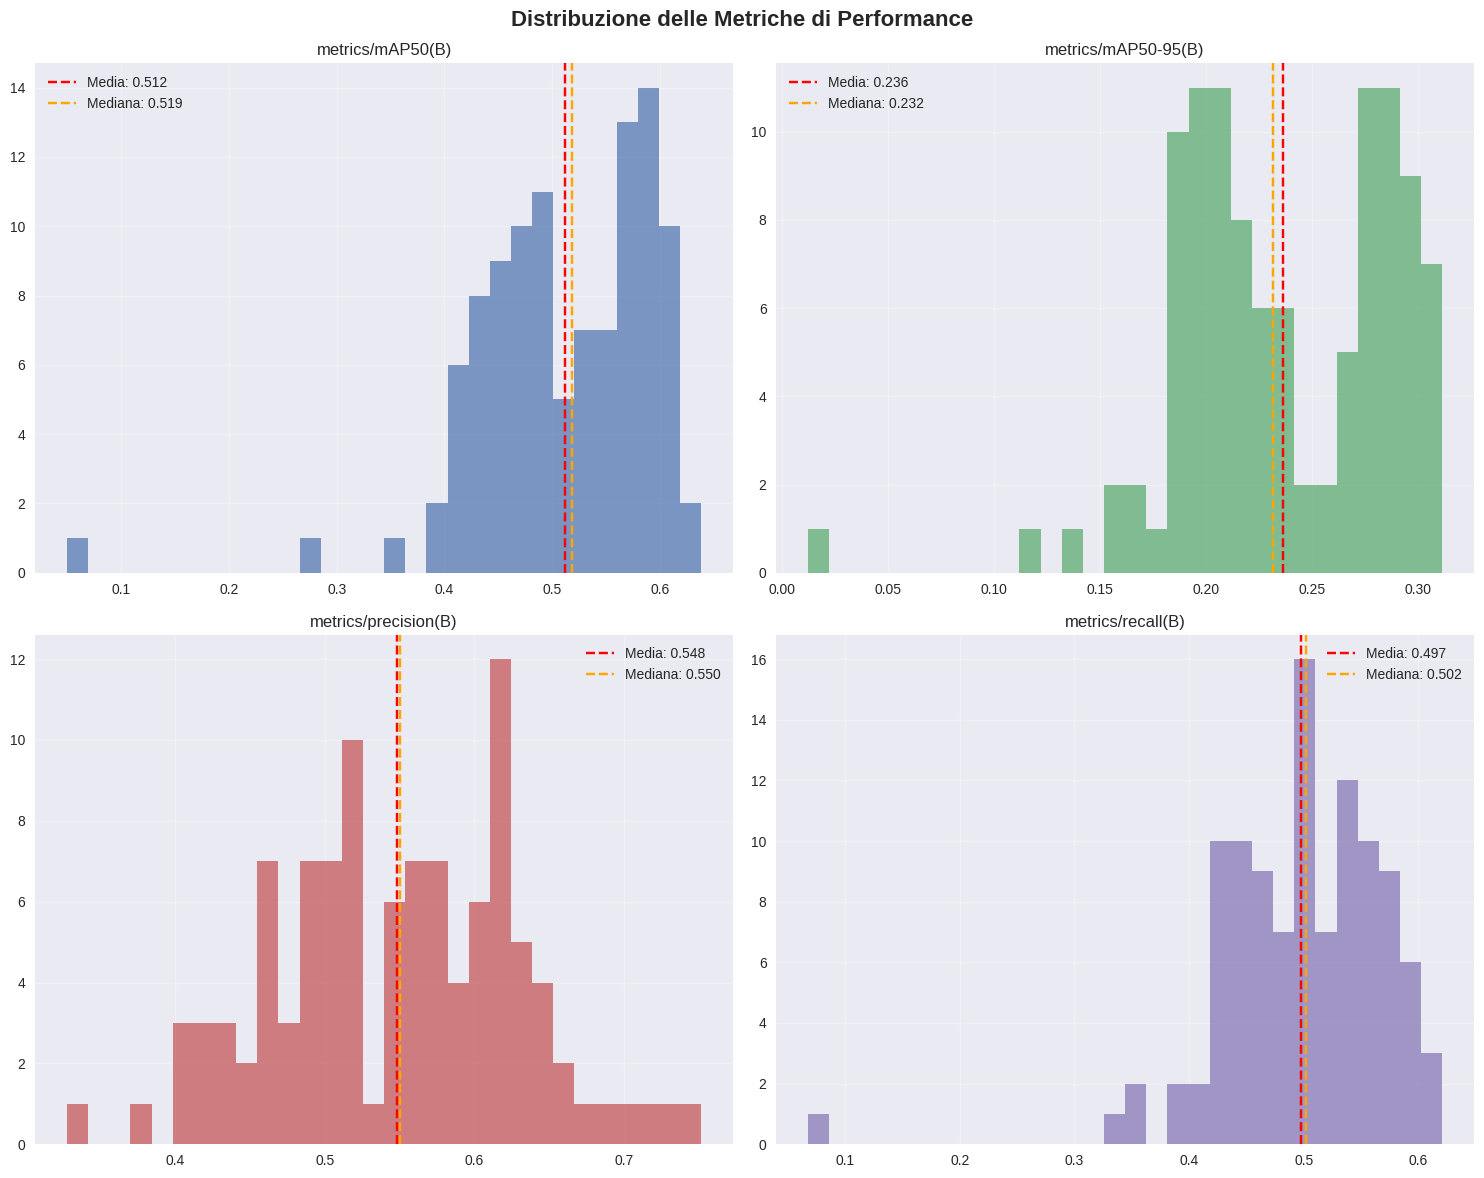

=== STATISTICHE METRICHE DI PERFORMANCE ===

metrics/mAP50(B):
  Media: 0.5118
  Mediana: 0.5188
  Std: 0.0835
  Min: 0.0497
  Max: 0.6385
  Q25: 0.4579
  Q75: 0.5773

metrics/mAP50-95(B):
  Media: 0.2362
  Mediana: 0.2316
  Std: 0.0513
  Min: 0.0121
  Max: 0.3114
  Q25: 0.1968
  Q75: 0.2822

metrics/precision(B):
  Media: 0.5484
  Mediana: 0.5504
  Std: 0.0820
  Min: 0.3274
  Max: 0.7517
  Q25: 0.4874
  Q75: 0.6149

metrics/recall(B):
  Media: 0.4973
  Mediana: 0.5017
  Std: 0.0735
  Min: 0.0675
  Max: 0.6210
  Q25: 0.4535
  Q75: 0.5493


In [5]:
# Distribuzione delle metriche principali
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Distribuzione delle Metriche di Performance', fontsize=16, fontweight='bold')

for i, metric in enumerate(available_performance[:4]):
    row, col = i // 2, i % 2
    
    # Istogramma
    axes[row, col].hist(df[metric].dropna(), bins=30, alpha=0.7, color=sns.color_palette()[i])
    axes[row, col].axvline(df[metric].mean(), color='red', linestyle='--', 
                          label=f'Media: {df[metric].mean():.3f}')
    axes[row, col].axvline(df[metric].median(), color='orange', linestyle='--', 
                          label=f'Mediana: {df[metric].median():.3f}')
    axes[row, col].set_title(f'{metric}')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistiche dettagliate
print("=== STATISTICHE METRICHE DI PERFORMANCE ===")
for metric in available_performance:
    data = df[metric].dropna()
    print(f"\n{metric}:")
    print(f"  Media: {data.mean():.4f}")
    print(f"  Mediana: {data.median():.4f}")
    print(f"  Std: {data.std():.4f}")
    print(f"  Min: {data.min():.4f}")
    print(f"  Max: {data.max():.4f}")
    print(f"  Q25: {data.quantile(0.25):.4f}")
    print(f"  Q75: {data.quantile(0.75):.4f}")

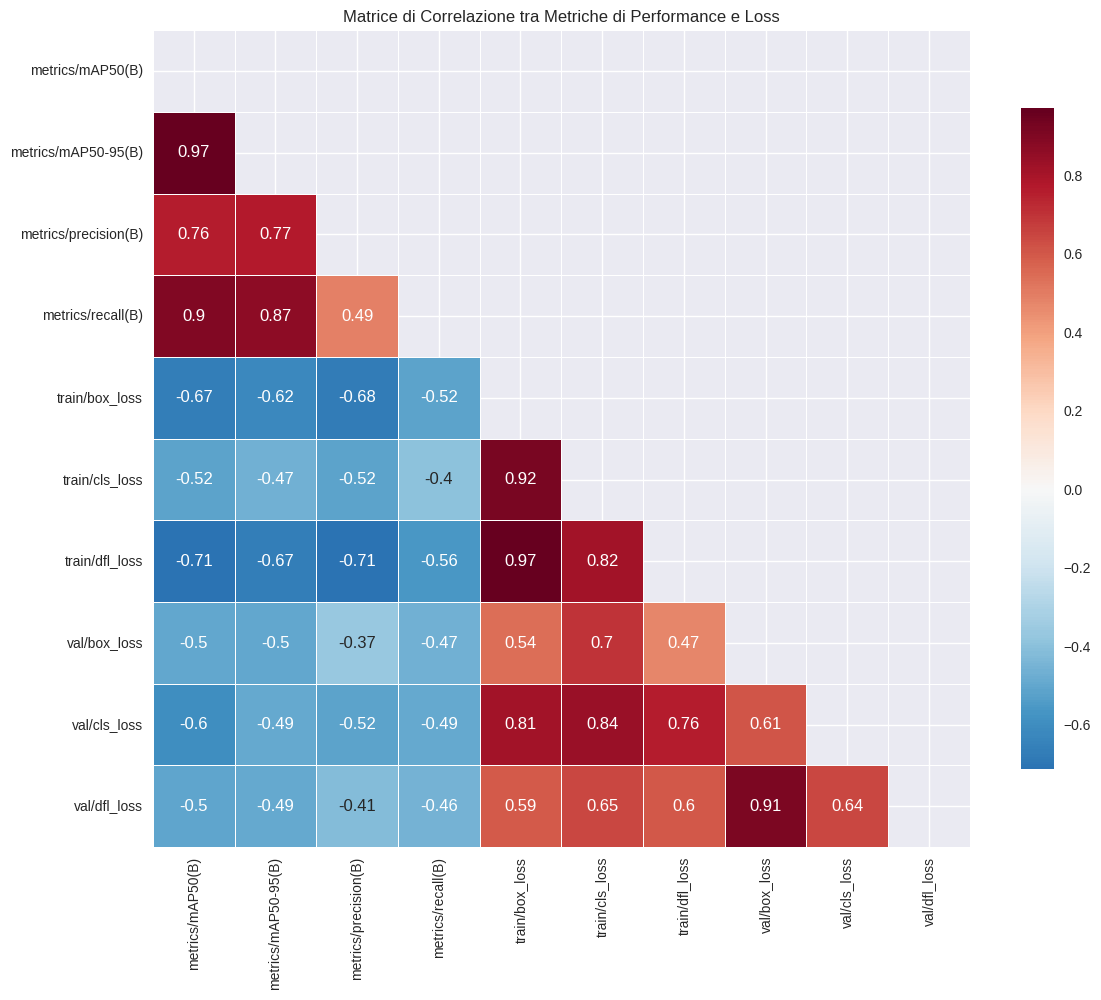

=== CORRELAZIONI PIÙ SIGNIFICATIVE ===
train/box_loss <-> train/dfl_loss: 0.971
metrics/mAP50(B) <-> metrics/mAP50-95(B): 0.967
train/box_loss <-> train/cls_loss: 0.916
val/box_loss <-> val/dfl_loss: 0.911
metrics/mAP50(B) <-> metrics/recall(B): 0.897
metrics/mAP50-95(B) <-> metrics/recall(B): 0.868
train/cls_loss <-> val/cls_loss: 0.837
train/cls_loss <-> train/dfl_loss: 0.815
train/box_loss <-> val/cls_loss: 0.813
metrics/mAP50-95(B) <-> metrics/precision(B): 0.771


In [6]:
# Matrice di correlazione tra tutte le metriche
all_metrics = available_performance + available_loss
correlation_matrix = df[all_metrics].corr()

# Heatmap delle correlazioni
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Matrice di Correlazione tra Metriche di Performance e Loss')
plt.tight_layout()
plt.show()

# Trova le correlazioni più forti
print("=== CORRELAZIONI PIÙ SIGNIFICATIVE ===")
corr_pairs = []
for i in range(len(all_metrics)):
    for j in range(i+1, len(all_metrics)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.5:  # Soglia per correlazioni significative
            corr_pairs.append((all_metrics[i], all_metrics[j], corr_val))

corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
for metric1, metric2, corr in corr_pairs[:10]:
    print(f"{metric1} <-> {metric2}: {corr:.3f}")

In [7]:
# Definisci una metrica composita per ranking
def calculate_composite_score(row):
    """Calcola un punteggio composito basato su tutte le metriche"""
    score = 0
    
    # Aggiungi metriche positive (più alto = meglio)
    for metric in available_performance:
        if pd.notna(row[metric]):
            normalized_val = (row[metric] - df[metric].min()) / (df[metric].max() - df[metric].min())
            score += normalized_val
    
    # Sottrai metriche negative (più basso = meglio) 
    for metric in available_loss:
        if pd.notna(row[metric]):
            normalized_val = (row[metric] - df[metric].min()) / (df[metric].max() - df[metric].min())
            score -= normalized_val
    
    return score

df['composite_score'] = df.apply(calculate_composite_score, axis=1)

# Top 10 configurazioni
top_10 = df.nlargest(10, 'composite_score')
print("=== TOP 10 CONFIGURAZIONI ===")
print(top_10[['composite_score'] + available_performance + available_loss].round(4))

# Analisi dei top performer
print("\n=== CARATTERISTICHE DEI TOP PERFORMER ===")
top_5 = df.nlargest(5, 'composite_score')
for param in available_hyperparams[:10]:  # Primi 10 iperparametri
    if param in df.columns:
        print(f"\n{param}:")
        print(f"  Top 5 - Media: {top_5[param].mean():.4f}, Std: {top_5[param].std():.4f}")
        print(f"  Tutti - Media: {df[param].mean():.4f}, Std: {df[param].std():.4f}")

=== TOP 10 CONFIGURAZIONI ===
    composite_score  metrics/mAP50(B)  metrics/mAP50-95(B)  \
33           3.4885            0.6145               0.3114   
31           3.3557            0.6385               0.3086   
26           3.2790            0.6324               0.3049   
1            3.2679            0.6083               0.3045   
13           3.0746            0.5821               0.2899   
40           3.0691            0.5964               0.2846   
47           3.0562            0.6049               0.3001   
36           3.0485            0.6068               0.3082   
12           3.0372            0.6023               0.2765   
53           3.0170            0.5853               0.2842   

    metrics/precision(B)  metrics/recall(B)  train/box_loss  train/cls_loss  \
33                0.6610             0.6059          1.2910          0.9111   
31                0.7158             0.5336          1.3142          0.8771   
26                0.6726             0.5650       

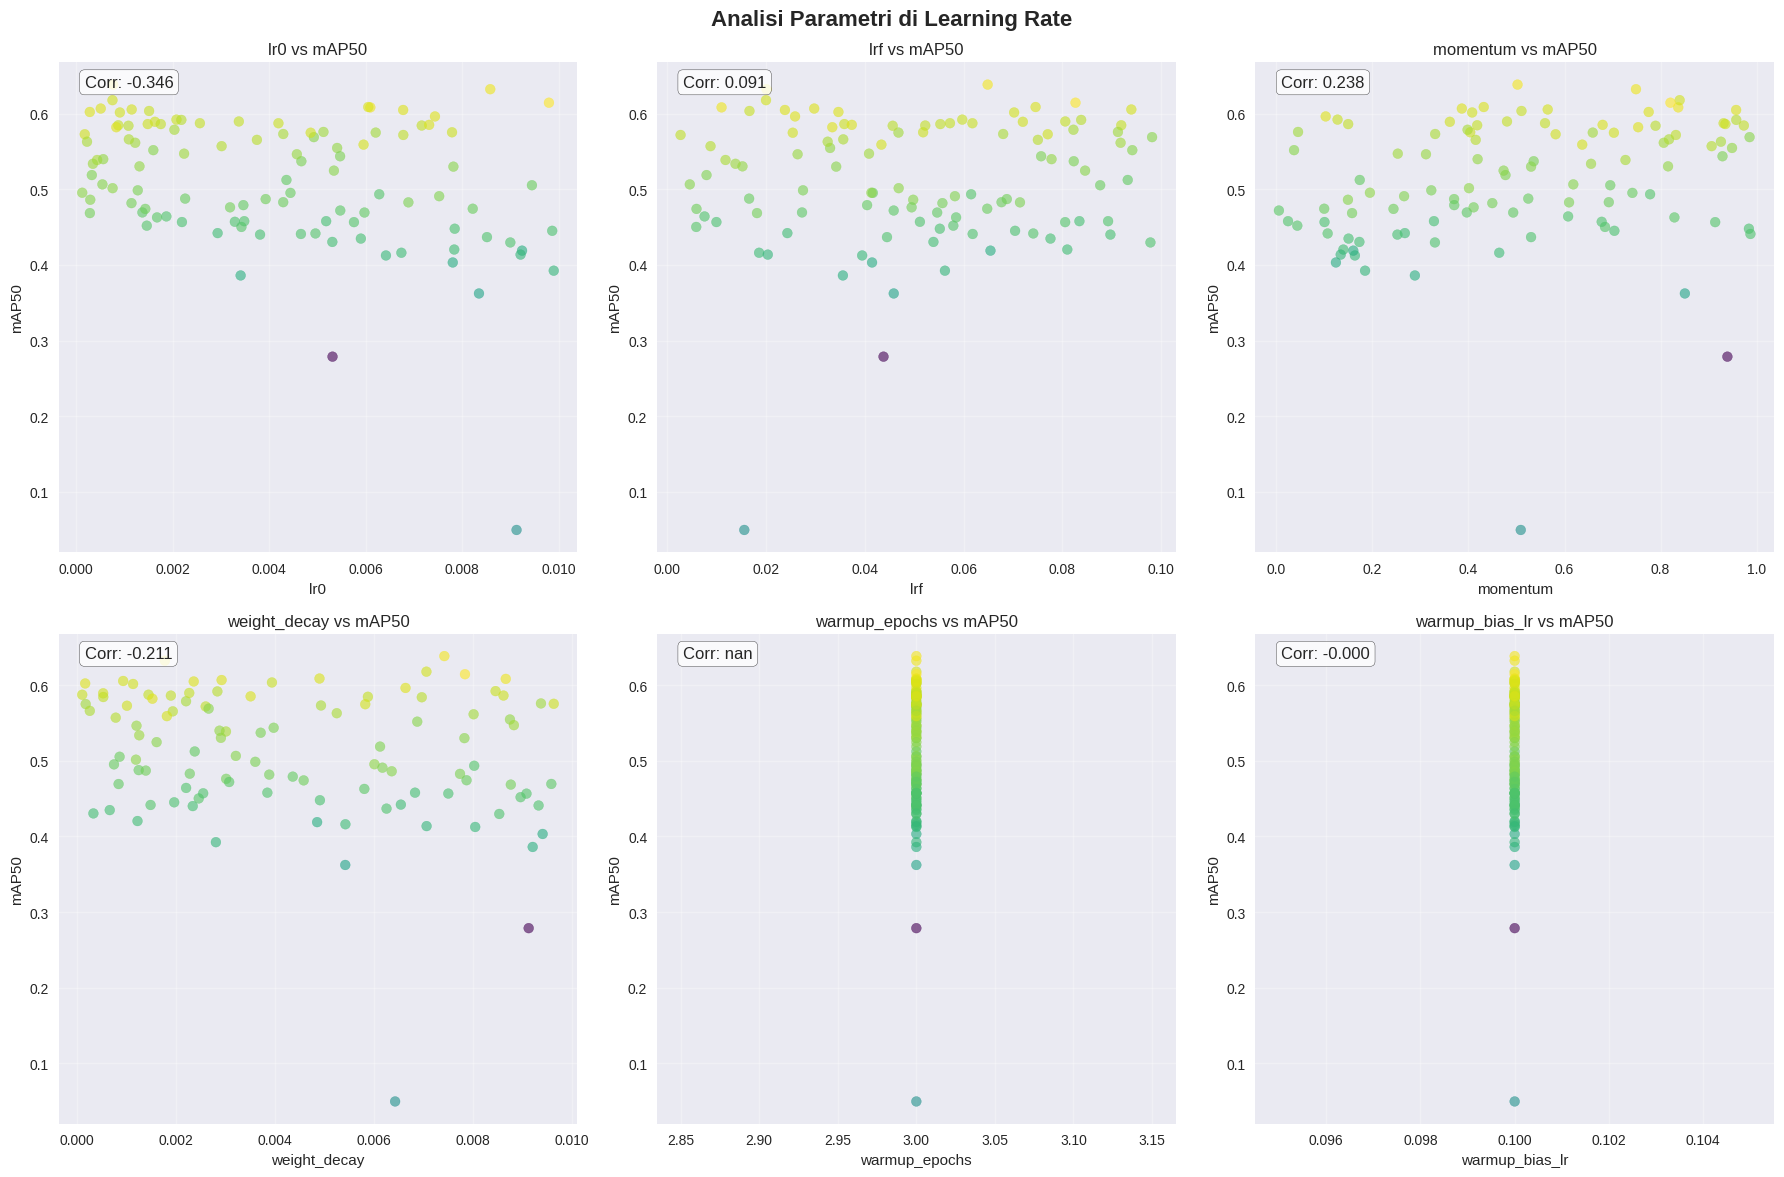

In [8]:
# Analisi dei learning rate parameters
lr_params = ['lr0', 'lrf', 'momentum', 'weight_decay', 'warmup_epochs', 'warmup_bias_lr']
available_lr_params = [p for p in lr_params if p in df.columns]

if available_lr_params:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Analisi Parametri di Learning Rate', fontsize=16, fontweight='bold')
    
    for i, param in enumerate(available_lr_params[:6]):
        row, col = i // 3, i % 3
        
        # Scatter plot con mAP50
        if 'metrics/mAP50(B)' in df.columns:
            scatter = axes[row, col].scatter(df[param], df['metrics/mAP50(B)'], 
                                           alpha=0.6, c=df['composite_score'], 
                                           cmap='viridis', s=50)
            axes[row, col].set_xlabel(param)
            axes[row, col].set_ylabel('mAP50')
            axes[row, col].set_title(f'{param} vs mAP50')
            axes[row, col].grid(True, alpha=0.3)
            
            # Calcola correlazione
            corr = df[param].corr(df['metrics/mAP50(B)'])
            axes[row, col].text(0.05, 0.95, f'Corr: {corr:.3f}', 
                               transform=axes[row, col].transAxes, 
                               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

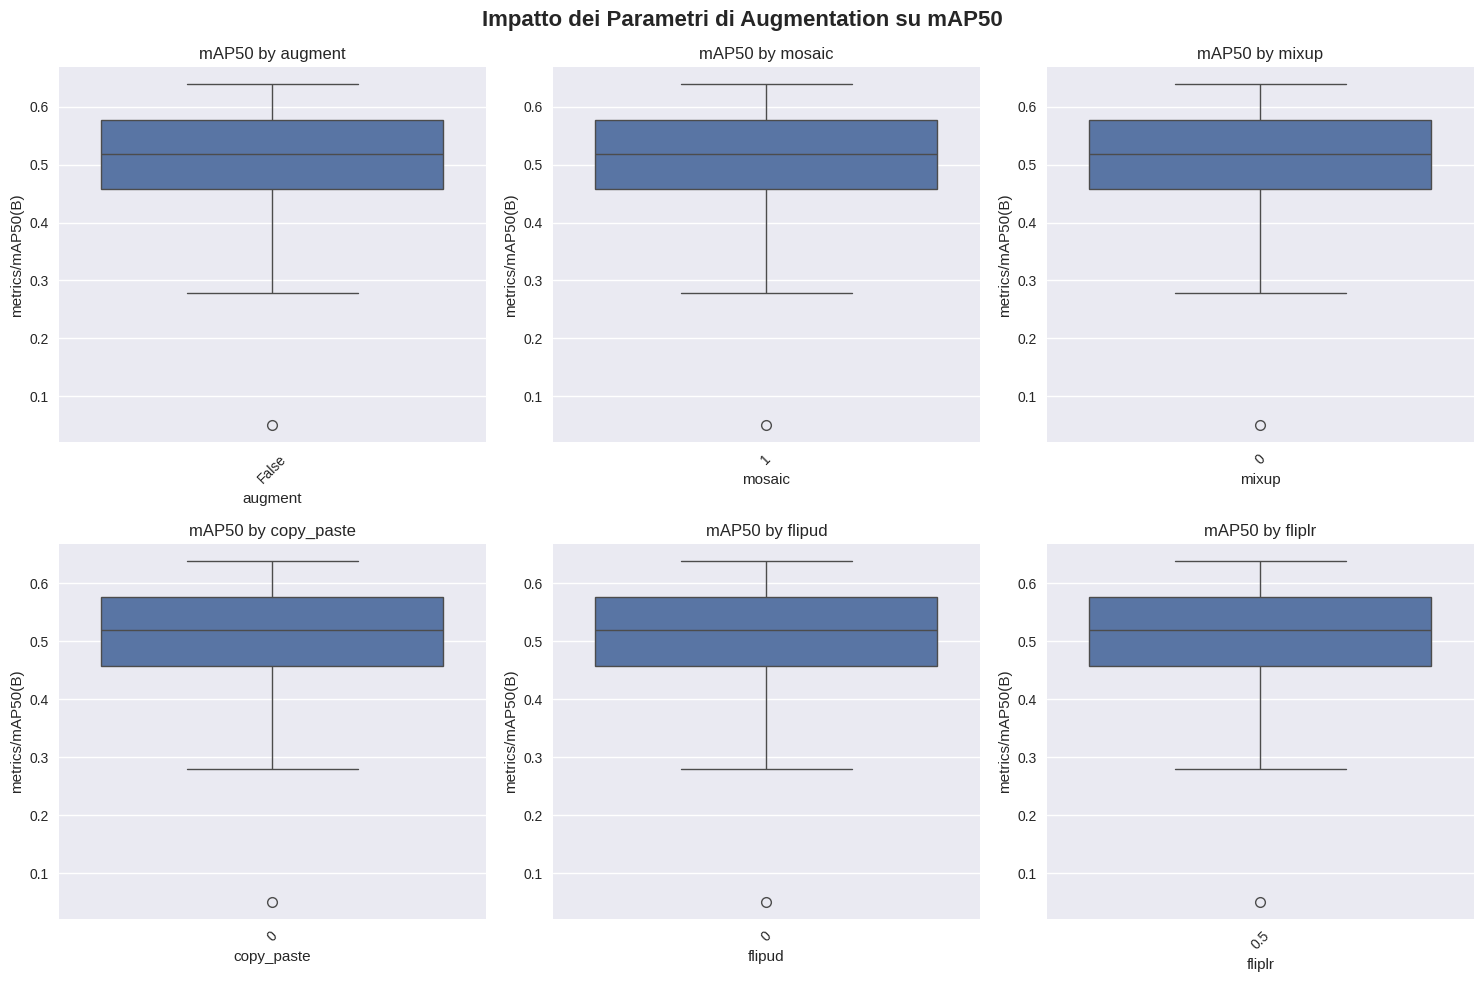

=== CORRELAZIONI PARAMETRI AUGMENTATION CON PERFORMANCE ===
degrees <-> mAP50: nan
translate <-> mAP50: -0.000
scale <-> mAP50: nan
shear <-> mAP50: nan
perspective <-> mAP50: nan
hsv_h <-> mAP50: 0.000
hsv_s <-> mAP50: 0.000
hsv_v <-> mAP50: -0.000
erasing <-> mAP50: -0.000
crop_fraction <-> mAP50: nan


In [9]:
# Parametri di data augmentation
aug_params = ['augment', 'mosaic', 'mixup', 'copy_paste', 'degrees', 'translate', 
              'scale', 'shear', 'perspective', 'hsv_h', 'hsv_s', 'hsv_v', 
              'flipud', 'fliplr', 'erasing', 'crop_fraction']
available_aug_params = [p for p in aug_params if p in df.columns]

# Box plot per parametri categorici di augmentation
categorical_aug = ['augment', 'mosaic', 'mixup', 'copy_paste', 'flipud', 'fliplr']
available_cat_aug = [p for p in categorical_aug if p in df.columns]

if available_cat_aug and 'metrics/mAP50(B)' in df.columns:
    n_plots = len(available_cat_aug)
    n_cols = 3
    n_rows = (n_plots + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    fig.suptitle('Impatto dei Parametri di Augmentation su mAP50', fontsize=16, fontweight='bold')
    
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, param in enumerate(available_cat_aug):
        row, col = i // n_cols, i % n_cols
        
        try:
            sns.boxplot(data=df, x=param, y='metrics/mAP50(B)', ax=axes[row, col])
            axes[row, col].set_title(f'mAP50 by {param}')
            axes[row, col].tick_params(axis='x', rotation=45)
        except Exception as e:
            axes[row, col].text(0.5, 0.5, f'Errore: {param}', 
                               ha='center', va='center', transform=axes[row, col].transAxes)
    
    # Nascondi subplot vuoti
    for i in range(n_plots, n_rows * n_cols):
        row, col = i // n_cols, i % n_cols
        axes[row, col].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Analisi dei parametri numerici di augmentation
numeric_aug = ['degrees', 'translate', 'scale', 'shear', 'perspective', 
               'hsv_h', 'hsv_s', 'hsv_v', 'erasing', 'crop_fraction']
available_num_aug = [p for p in numeric_aug if p in df.columns]

print("=== CORRELAZIONI PARAMETRI AUGMENTATION CON PERFORMANCE ===")
for param in available_num_aug:
    if 'metrics/mAP50(B)' in df.columns:
        corr = df[param].corr(df['metrics/mAP50(B)'])
        print(f"{param} <-> mAP50: {corr:.3f}")

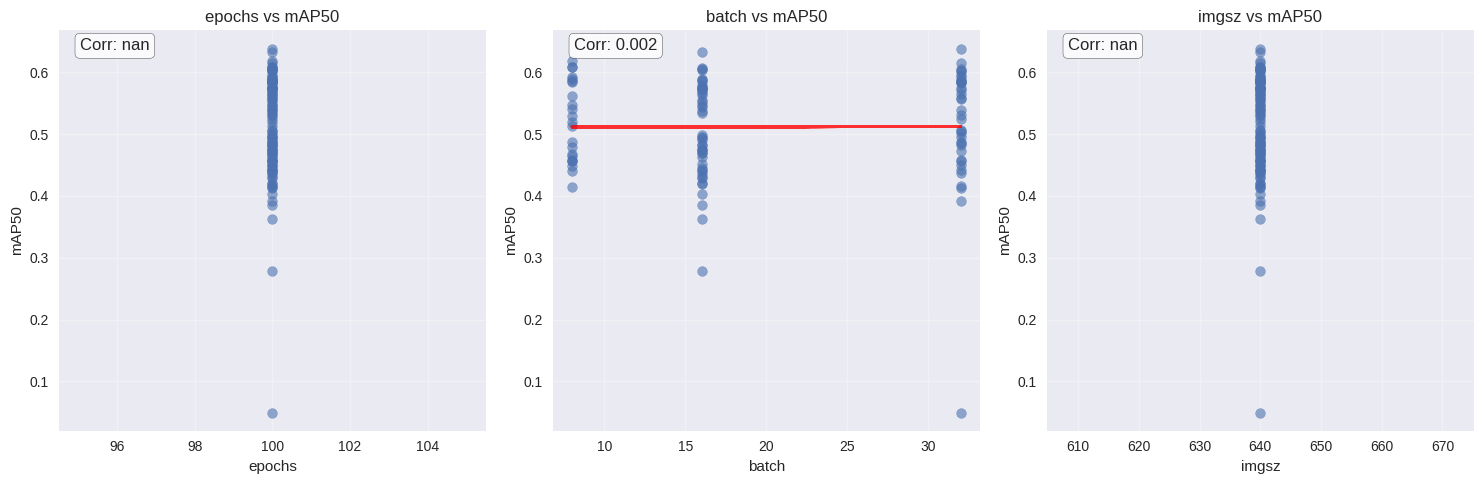

=== TRADE-OFF PERFORMANCE vs COMPLESSITÀ ===
model/GFLOPs <-> mAP50: 0.082
model/parameters <-> mAP50: -0.082
model/speed_PyTorch(ms) <-> mAP50: -0.184


In [10]:
# Parametri di architettura e training
model_params = ['epochs', 'batch', 'imgsz']
available_model_params = [p for p in model_params if p in df.columns]

if available_model_params:
    fig, axes = plt.subplots(1, len(available_model_params), figsize=(5*len(available_model_params), 5))
    if len(available_model_params) == 1:
        axes = [axes]
    
    for i, param in enumerate(available_model_params):
        if 'metrics/mAP50(B)' in df.columns:
            # Scatter plot con trend line
            x = df[param].dropna()
            y = df['metrics/mAP50(B)'][df[param].notna()]
            
            axes[i].scatter(x, y, alpha=0.6, s=50)
            
            # Aggiungi trend line
            z = np.polyfit(x, y, 1)
            p = np.poly1d(z)
            axes[i].plot(x, p(x), "r--", alpha=0.8)
            
            axes[i].set_xlabel(param)
            axes[i].set_ylabel('mAP50')
            axes[i].set_title(f'{param} vs mAP50')
            axes[i].grid(True, alpha=0.3)
            
            # Correlazione
            corr = df[param].corr(df['metrics/mAP50(B)'])
            axes[i].text(0.05, 0.95, f'Corr: {corr:.3f}', 
                        transform=axes[i].transAxes,
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# Analisi delle dimensioni del modello e velocità
model_metrics = ['model/GFLOPs', 'model/parameters', 'model/speed_PyTorch(ms)']
available_model_metrics = [m for m in model_metrics if m in df.columns]

if available_model_metrics:
    print("=== TRADE-OFF PERFORMANCE vs COMPLESSITÀ ===")
    for metric in available_model_metrics:
        if 'metrics/mAP50(B)' in df.columns:
            corr = df[metric].corr(df['metrics/mAP50(B)'])
            print(f"{metric} <-> mAP50: {corr:.3f}")

=== ANALISI DEI CLUSTER ===

Cluster 0 (n=15):
  mAP50 medio: 0.5255
  mAP50 std: 0.0596
  Composite Score medio: 2.1245
  Caratteristiche principali:
    lr0: 0.002 (vs globale: 0.004)
    lrf: 0.067 (vs globale: 0.051)
    momentum: 0.272 (vs globale: 0.508)
    weight_decay: 0.004 (vs globale: 0.004)

Cluster 1 (n=17):
  mAP50 medio: 0.5559
  mAP50 std: 0.0551
  Composite Score medio: 2.5432
  Caratteristiche principali:
    lr0: 0.004 (vs globale: 0.004)
    lrf: 0.026 (vs globale: 0.051)
    momentum: 0.781 (vs globale: 0.508)
    weight_decay: 0.003 (vs globale: 0.004)

Cluster 2 (n=25):
  mAP50 medio: 0.4610
  mAP50 std: 0.1208
  Composite Score medio: 1.2858
  Caratteristiche principali:
    lr0: 0.007 (vs globale: 0.004)
    weight_decay: 0.007 (vs globale: 0.004)

Cluster 3 (n=21):
  mAP50 medio: 0.5078
  mAP50 std: 0.0624
  Composite Score medio: 1.8367
  Caratteristiche principali:
    lr0: 0.002 (vs globale: 0.004)
    lrf: 0.027 (vs globale: 0.051)
    momentum: 0.443 (vs

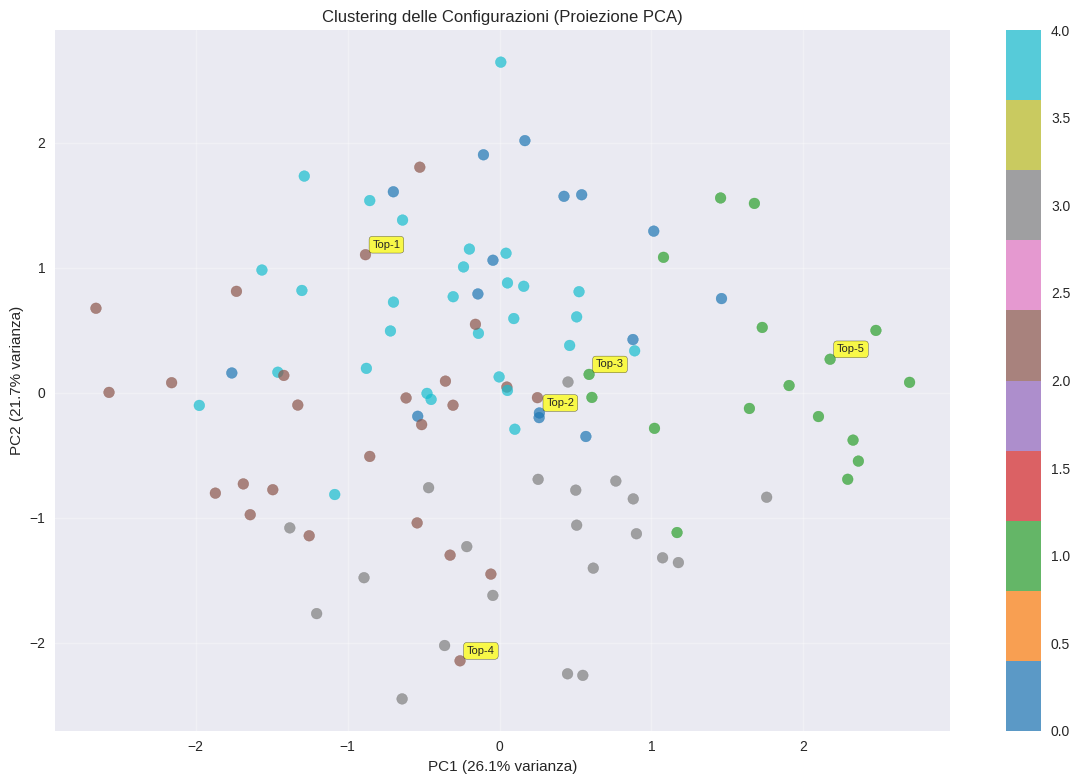

In [11]:
# Prepara i dati per clustering
cluster_features = available_hyperparams[:15]  # Usa i primi 15 iperparametri
cluster_data = df[cluster_features].fillna(df[cluster_features].mean())

# Standardizza i dati
scaler = StandardScaler()
cluster_data_scaled = scaler.fit_transform(cluster_data)

# Applica K-means clustering
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(cluster_data_scaled)

# Analizza i cluster
print("=== ANALISI DEI CLUSTER ===")
for cluster_id in range(n_clusters):
    cluster_data = df[df['cluster'] == cluster_id]
    print(f"\nCluster {cluster_id} (n={len(cluster_data)}):")
    
    if 'metrics/mAP50(B)' in df.columns:
        print(f"  mAP50 medio: {cluster_data['metrics/mAP50(B)'].mean():.4f}")
        print(f"  mAP50 std: {cluster_data['metrics/mAP50(B)'].std():.4f}")
    
    print(f"  Composite Score medio: {cluster_data['composite_score'].mean():.4f}")
    
    # Caratteristiche distintive del cluster
    print("  Caratteristiche principali:")
    for param in cluster_features[:5]:
        mean_val = cluster_data[param].mean()
        global_mean = df[param].mean()
        if abs(mean_val - global_mean) > 0.1 * df[param].std():
            print(f"    {param}: {mean_val:.3f} (vs globale: {global_mean:.3f})")

# Visualizza i cluster con PCA
pca = PCA(n_components=2)
cluster_pca = pca.fit_transform(cluster_data_scaled)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(cluster_pca[:, 0], cluster_pca[:, 1], 
                     c=df['cluster'], cmap='tab10', alpha=0.7, s=60)
plt.colorbar(scatter)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} varianza)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} varianza)')
plt.title('Clustering delle Configurazioni (Proiezione PCA)')
plt.grid(True, alpha=0.3)

# Aggiungi etichette per i top performer
top_5_indices = df.nlargest(5, 'composite_score').index
for idx in top_5_indices:
    plt.annotate(f'Top-{list(top_5_indices).index(idx)+1}', 
                xy=(cluster_pca[idx, 0], cluster_pca[idx, 1]),
                xytext=(5, 5), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                fontsize=8)

plt.tight_layout()
plt.show()

0.0098990984374759
0.0981443226207957
0.987281463463806
0.0096332925575265
3
0.1
7.5
0.5
1.5
100
32
640
False
1
0
0
0
0.1
0.5
0
0
0.015
0.7
0.4
0
0.5
0.4
1


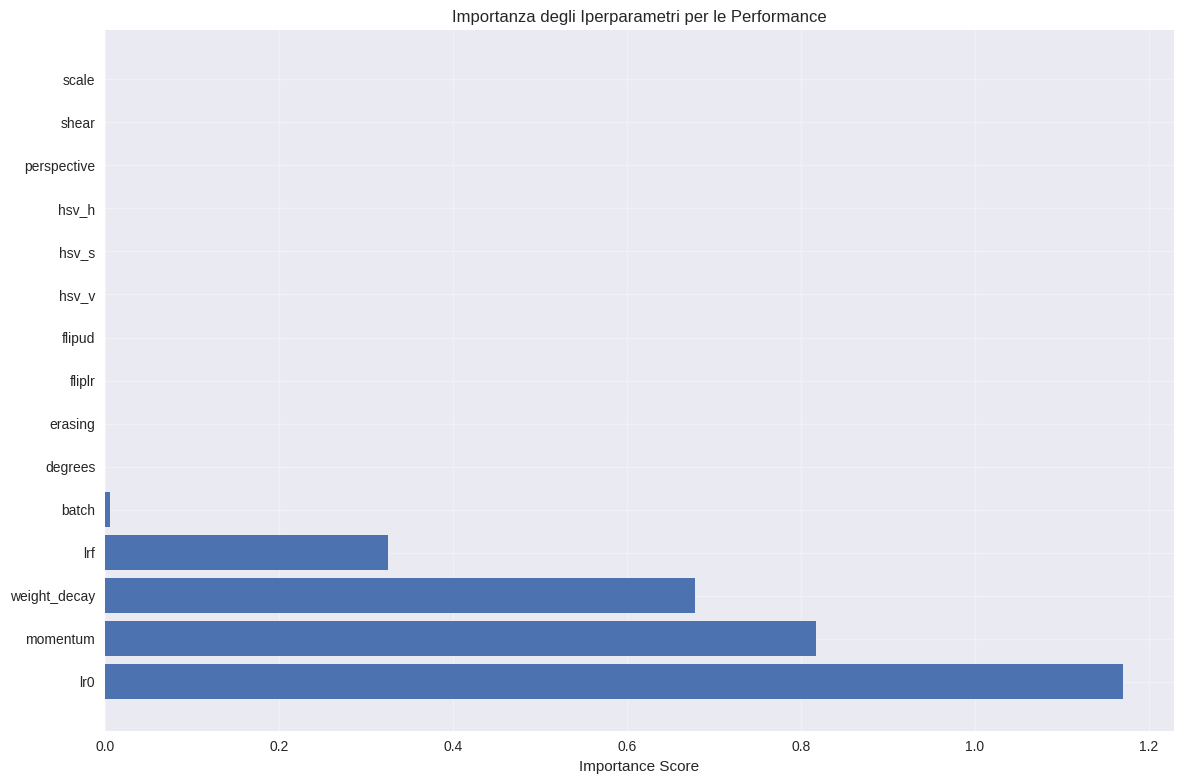

=== RANKING IMPORTANZA IPERPARAMETRI ===
 1. lr0: 1.1702
 2. momentum: 0.8177
 3. weight_decay: 0.6783
 4. lrf: 0.3258
 5. batch: 0.0061
 6. degrees: 0.0000
 7. erasing: 0.0000
 8. fliplr: 0.0000
 9. flipud: 0.0000
10. hsv_v: 0.0000


In [14]:
# Calcola l'importanza degli iperparametri basata sulla varianza delle performance
def calculate_hyperparameter_importance():
    importance_scores = {}
    
    for param in available_hyperparams:
        if param in df.columns and 'metrics/mAP50(B)' in df.columns:
            # Calcola la correlazione assoluta
            corr = abs(df[param].corr(df['metrics/mAP50(B)']))
            
            # Calcola l'effetto della variazione del parametro
            param_std = df[param].std()
            print(df[param].max())
            param_range = df[param].max() - df[param].min() if df[param].max() and df[param].min() else 0
            
            # Score combinato
            importance_scores[param] = corr * (param_range / param_std) if param_std > 0 else 0
    
    return importance_scores

importance = calculate_hyperparameter_importance()
importance_df = pd.DataFrame(list(importance.items()), 
                           columns=['Parameter', 'Importance']).sort_values('Importance', ascending=False)

# Visualizza l'importanza degli iperparametri
plt.figure(figsize=(12, 8))
top_params = importance_df.head(15)
plt.barh(range(len(top_params)), top_params['Importance'])
plt.yticks(range(len(top_params)), top_params['Parameter'])
plt.xlabel('Importance Score')
plt.title('Importanza degli Iperparametri per le Performance')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("=== RANKING IMPORTANZA IPERPARAMETRI ===")
for i, (param, score) in enumerate(importance_df.head(10).values):
    print(f"{i+1:2d}. {param}: {score:.4f}")

In [15]:
# Identifica la configurazione ottimale
best_config = df.loc[df['composite_score'].idxmax()]

print("="*60)
print("🎯 CONFIGURAZIONE OTTIMALE IDENTIFICATA")
print("="*60)

print(f"Composite Score: {best_config['composite_score']:.4f}")
print(f"Run ID: {best_config.get('run_id', 'N/A')}")

print("\n📊 METRICHE DI PERFORMANCE:")
for metric in available_performance:
    print(f"  {metric}: {best_config[metric]:.4f}")

print("\n📉 LOSS VALUES:")
for metric in available_loss:
    print(f"  {metric}: {best_config[metric]:.4f}")

print("\n⚙️ IPERPARAMETRI CHIAVE:")
important_params = importance_df.head(10)['Parameter'].values
for param in important_params:
    if param in df.columns:
        print(f"  {param}: {best_config[param]}")

# Confronta con la media
print("\n" + "="*60)
print("📈 CONFRONTO CON LA MEDIA DEL DATASET")
print("="*60)

for metric in available_performance:
    improvement = ((best_config[metric] - df[metric].mean()) / df[metric].mean()) * 100
    print(f"{metric}: {improvement:+.2f}% rispetto alla media")

# Analisi di robustezza
print("\n" + "="*60)
print("🔍 ANALISI DI ROBUSTEZZA")
print("="*60)

# Trova configurazioni simili alla migliore
similarity_threshold = 0.8
similar_configs = []

for idx, row in df.iterrows():
    if idx != df['composite_score'].idxmax():
        similarity = 0
        count = 0
        for param in important_params[:5]:  # Usa i 5 parametri più importanti
            if param in df.columns:
                if abs(row[param] - best_config[param]) / (df[param].std() + 1e-6) < 1:
                    similarity += 1
                count += 1
        
        if count > 0 and similarity / count >= similarity_threshold:
            similar_configs.append((idx, row['composite_score']))

if similar_configs:
    print(f"Trovate {len(similar_configs)} configurazioni simili con performance comparabili")
    similar_scores = [score for _, score in similar_configs]
    print(f"Score medio configurazioni simili: {np.mean(similar_scores):.4f}")
    print(f"Deviazione standard: {np.std(similar_scores):.4f}")
else:
    print("⚠️  La configurazione ottimale è unica - potrebbe essere overfitting")

# Raccomandazioni finali
print("\n" + "="*60)
print("💡 RACCOMANDAZIONI FINALI")
print("="*60)

print("1. CONFIGURAZIONE RACCOMANDATA:")
print("   Usa la configurazione ottimale identificata sopra")

print("\n2. PARAMETRI CRITICI DA MONITORARE:")
for i, param in enumerate(important_params[:5]):
    print(f"   {i+1}. {param}")

print("\n3. SUGGERIMENTI PER ULTERIORI ESPERIMENTI:")
print("   - Fai fine-tuning attorno ai valori ottimali identificati")
print("   - Testa combinazioni degli iperparametri più importanti")
print("   - Considera l'early stopping se non già implementato")

if len(similar_configs) < 3:
    print("   - Aumenta il numero di esperimenti per validare la robustezza")

print("\n4. TRADE-OFF DA CONSIDERARE:")
if 'model/speed_PyTorch(ms)' in df.columns:
    speed_corr = df['model/speed_PyTorch(ms)'].corr(df['metrics/mAP50(B)'])
    if speed_corr > 0.3:
        print("   - Performance vs Velocità di inferenza (correlazione positiva)")
    elif speed_corr < -0.3:
        print("   - Performance vs Velocità di inferenza (correlazione negativa)")

if 'model/parameters' in df.columns:
    param_corr = df['model/parameters'].corr(df['metrics/mAP50(B)'])
    if param_corr > 0.3:
        print("   - Performance vs Dimensione modello (più parametri = migliori performance)")
    elif param_corr < -0.3:
        print("   - Performance vs Dimensione modello (meno parametri = migliori performance)")

print("\n" + "="*60)
print("✅ ANALISI COMPLETATA")
print("="*60)

🎯 CONFIGURAZIONE OTTIMALE IDENTIFICATA
Composite Score: 3.4885
Run ID: 1ts1d6um

📊 METRICHE DI PERFORMANCE:
  metrics/mAP50(B): 0.6145
  metrics/mAP50-95(B): 0.3114
  metrics/precision(B): 0.6610
  metrics/recall(B): 0.6059

📉 LOSS VALUES:
  train/box_loss: 1.2910
  train/cls_loss: 0.9111
  train/dfl_loss: 1.1098
  val/box_loss: 1.9817
  val/cls_loss: 1.6511
  val/dfl_loss: 1.5086

⚙️ IPERPARAMETRI CHIAVE:
  lr0: 0.009799360489695
  momentum: 0.8206979179968263
  weight_decay: 0.007840277810131
  lrf: 0.0826529546355827
  batch: 32
  degrees: 0
  erasing: 0.4
  fliplr: 0.5
  flipud: 0
  hsv_v: 0.4

📈 CONFRONTO CON LA MEDIA DEL DATASET
metrics/mAP50(B): +20.07% rispetto alla media
metrics/mAP50-95(B): +31.83% rispetto alla media
metrics/precision(B): +20.54% rispetto alla media
metrics/recall(B): +21.83% rispetto alla media

🔍 ANALISI DI ROBUSTEZZA
Trovate 1 configurazioni simili con performance comparabili
Score medio configurazioni simili: 1.6072
Deviazione standard: 0.0000

💡 RACCOMA

In [16]:
# Salva i risultati dell'analisi
results_summary = {
    'best_config_index': df['composite_score'].idxmax(),
    'best_composite_score': df['composite_score'].max(),
    'hyperparameter_importance': importance_df.head(10).to_dict(),
    'top_10_configs': top_10[available_performance + available_loss + ['composite_score']].to_dict(),
    'cluster_analysis': df.groupby('cluster')['composite_score'].agg(['mean', 'std', 'count']).to_dict()
}

# Salva la configurazione ottimale in un file separato
optimal_config = best_config[available_hyperparams].to_dict()

print("💾 Per salvare i risultati, decommenta le righe seguenti:")
print("# import json")
print("# with open('yolo_eda_results.json', 'w') as f:")
print("#     json.dump(results_summary, f, indent=2)")
print("# ")
print("# with open('optimal_yolo_config.json', 'w') as f:")
print("#     json.dump(optimal_config, f, indent=2)")

print("\n🎉 EDA completata! Usa le raccomandazioni sopra per ottimizzare il tuo modello YOLO.")

💾 Per salvare i risultati, decommenta le righe seguenti:
# import json
# with open('yolo_eda_results.json', 'w') as f:
#     json.dump(results_summary, f, indent=2)
# 
# with open('optimal_yolo_config.json', 'w') as f:
#     json.dump(optimal_config, f, indent=2)

🎉 EDA completata! Usa le raccomandazioni sopra per ottimizzare il tuo modello YOLO.
